<a href="https://colab.research.google.com/github/rland93/pendsim/blob/master/notebooks/state_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set to `True` if you are running this notebook in a Google Colab environment.

In [1]:
GOOGLE_COLAB = False

In [2]:
if not GOOGLE_COLAB:
    %cd ../
else:
    !pip install pendsim

/Users/ms/pendsim


In [3]:
from pendsim import sim, controller, viz, utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import HTML
print(controller.__file__)

/Users/ms/.pyenv/versions/pendsim/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


/Users/ms/pendsim/pendsim/controller.py


# State Estimation with Unscented Kalman Filter (UKF)
All feedback control relies on measurements of the system state to inform the control actuation. This makes an accurate measurement or an estimation of the system state a very important factor in feedback control system performance. Here, we look at the Unscented Kalman Filter as a state estimator, and evaluate how a PID controller with accurate state estimation compares to the performance of one that does not.

State estimation is the problem of estimating the true system state from noisy, incomplete, or lower-dimensional sensor inputs. A commonly used state estimator is the Kalman Filter. Here, we will use the Unscented Kalman Filter (UKF) to estimate the state, and see the impact that improved state estimation has on control outcomes, in comparison to simply using the noisy states as they are measured.

In this example, we do have measurements for every dimension of the state, and we also have measurements at every feedback control step. However, the measurements we do have are noisy. So we are using UKF here to improve the *state feedback* outcome.

Why use an Unscented Kalman Filter over an Extended or standard Kalman Filter?

For one, we have a non-linear system. Because a simple Kalman Filter assumes linearity in system dynamics, it's likely that it will diverge, because the evolution of the pendulum system cannot be modeled linearly. An Extended Kalman Filter would improve this somewhat; it propagates the distribution of the inputs through a first-order linerization of the non-linear system. But, a first order linear approximation is just that: an approximation. This leads us to the UKF; in the UKF, a carefully chosen set of sample points is propagated through the *true* (non-linear!) system, which results in an improved estimation outcome.

Such an estimate would not see errors inherent to treating of the system as linear (as in the Kalman Filter case) or errors arising from dropping higher-order terms from linearized system at each state (as in the Extended Kalman Filter case).

With full state feedback, this filter will diverge only in the presence of un-modeled dynamics (external forces) or noise that is non-gaussian.

For more information about the Unscented Kalman Filter, see https://groups.seas.harvard.edu/courses/cs281/papers/unscented.pdf. This module (and the UKF augmented controllers within) uses the wonderful python package `filterpy`, which has a companion [textbook](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/) that covers filtering in detail.

We will see the benefit of the filter, as well as its drawback, by introducing an un-modeled disturbance at $t=3$s. The benefit we see in the form of significantly improved estimation of state in the well-modeled region, and the drawback, in the form of a state-estimate divergence, where the system is ill-modeled. So, we introduce (and chart) an external force:

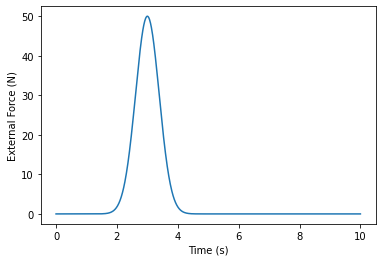

In [4]:
# a 50N bump at 3s
c1, fshift = 50, 3
def force_fn(t):
    return c1 * np.exp(-((t - fshift) ** 2 /0.3))

force_fn_ts = np.linspace(0,10, 1000)
force_fn_fs = np.apply_along_axis(force_fn, 0, force_fn_ts)

_, ax1 = plt.subplots()

ax1.plot(force_fn_ts, force_fn_fs)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("External Force (N)")
plt.show()

Simulation time of 10s, with timestep 0.01s.

The pendulum has $M=4$kg, $m=1$kg, $l=3$m.

The initial state is $\textbf{x}=[x, \dot{x}, \theta, \dot{\theta}] = [0, 0, 0.05 rad, 0]$.

In [5]:
dt, t_final = 0.01, 8
# slightly tipped over
pend = sim.Pendulum(4,1,3.0, initial_state=np.array([0,0,0.05,0]))

We introduce a `noise_scale` to simulate gaussian noise on the system. This adds sensor noise, with a mean of the true variable value, and a variance scaled for each variable. Changing this vector scales the noise.

In [6]:
noise_scale = np.array([.1,.1,.1,.1])
simu = sim.Simulation(dt, t_final, force_fn, noise_scale=noise_scale)

Here, we have two controllers: `pid` which takes action on the raw sensor measurement, and `pid_ukf` which estimates the state, and takes action based on the estimation. 

If its estimation is good, `pid_ukf` should outperform `pid`.

The parameter `var_t` passed into `pid_ukf` is the window, in seconds, over which to estimate the variance of the measurements: a larger window produces a more accurate noise estimate, but is not as responsive.

In [7]:
kp, ki, kd = (300.0, 0.0, 30.0)

pid = controller.PID((kp, ki, kd))
pid_ukf = controller.PID_UKF((kp, ki, kd), pend, dt, var_t=0.25)

In [8]:
res_pid = simu.simulate(pend, pid)
res_pid_ukf = simu.simulate(pend, pid_ukf)

100%|████████████████████████████████████████| 800/800 [00:04<00:00, 177.47it/s]


This generates a plot of the state, true state, and measured state for each state variable. We are most interested in $\theta$, but we also might consider the other states to be important for different controllers or policies.

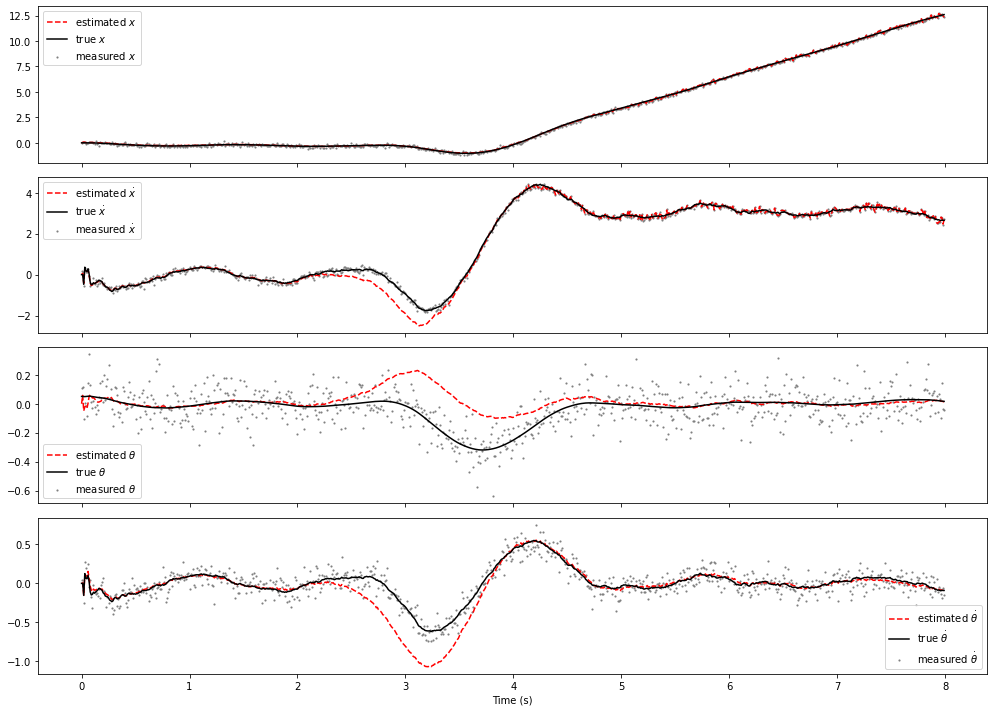

In [9]:
_, ax = plt.subplots(nrows=4, tight_layout=True, sharex=True, figsize=(14,10))
labels = [r'$x$', r'$\dot{x}$', r'$\theta$', r'$\dot{\theta}$']
for i, (sp, su, l) in enumerate(zip(res_pid['state'], res_pid_ukf['state'], labels)):
  ax[i].scatter(res_pid_ukf.index, res_pid_ukf[('measured state', su)].values, color="grey", label = 'measured ' + l, marker = '.', s=5)
  ax[i].plot(res_pid_ukf[('est', su)] , "r--",  label = 'estimated ' + l)
  ax[i].plot(res_pid_ukf[('state', su)], "k-", label = 'true ' + l)
  ax[i].legend()
ax[3].set_xlabel("Time (s)")
plt.show()

Now, we can see the effect of our filter. The estimated state almost perfectly tracks with the true state. In fact, we used the exact same model in the filter as in the simulator, so theoretically, this is a "perfect" estimator: the estimated state tracks the simulated state perfectly, since the state noise is gaussian. It's nearly perfect... except, of course, in the area centered at $t=3$s where there is the external force! That external force is NOT part of the filter's understanding of the system dynamics (how could it be? It's external!) so of course, in that area, the filter has a hard time, and its estimate of the system state diverges from the true state. 

Once the external force is gone, the filter finds the true value again, because the system evolves in accordance with its prediction.

Now, let's look at how the presence of the state estimator improves the control outcome.

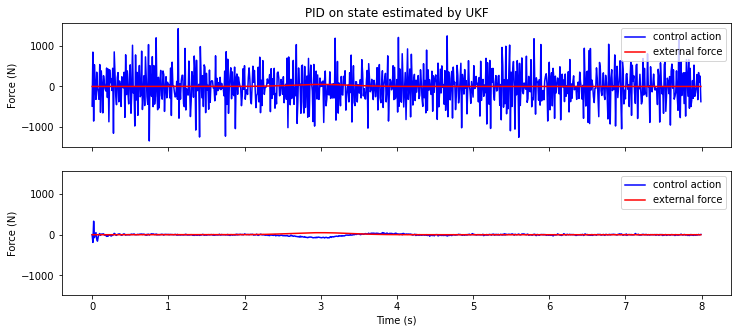

In [10]:
_, ax3 = plt.subplots(figsize=(12,5), nrows=2, sharey=True, sharex=True)
ax3[0].set_title("PID on noisy state measurements")
ax3[0].plot(res_pid[("control action", "control action")], 'b', label='control action')
ax3[0].plot(res_pid[("forces", "forces")], 'r', label='external force')
ax3[0].legend()
ax3[0].set_title("PID on state estimated by UKF")
ax3[1].plot(res_pid_ukf[('control action', "control action")], 'b', label='control action')
ax3[1].plot(res_pid_ukf[('forces', 'forces')], 'r', label='external force')
ax3[1].legend()
for a in ax3:
    a.set_ylabel("Force (N)")
ax3[1].set_xlabel("Time (s)")
plt.show()

Here, we see perhaps the clearest benefit of the state estimator: a significant reduction in actuation. Not only does the state estimator confer stability benefits, it also prevents the controller from actuating based on state noise. This means a reduction in wear, energy use, (in a physical system), etc.

Quantitatively, this means less control actuation. If we assume that the controller takes an equal amount of energy to push left as it does right, then we can get an approximate comparison the energy between both controlleres by adding each control action

In [11]:
pid_sum = np.abs(res_pid[("control action", "control action")].values).sum() / t_final
pid_ukf_sum = np.abs(res_pid_ukf[("control action", "control action")].values).sum() / t_final
print("PID Only: {}".format(round(pid_sum,2)))
print("PID with State Estimator: {}".format(round(pid_ukf_sum,2)))

PID Only: 35486.95
PID with State Estimator: 1508.17


If energy use is an issue, this is a significant improvement!

Finally, we can qualitatively see the difference. First, the standard PID, which actuates directly based on noisy state measurements:

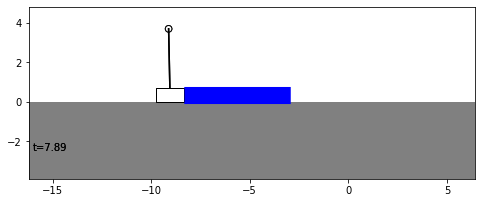

In [12]:
visu1 = viz.Visualizer(res_pid, pend, dt, speed=1)
anim1 = visu1.animate()
HTML(anim1.to_html5_video())

Then, the PID with state estimation, where the controller actuates based on the UKF-filtered state:

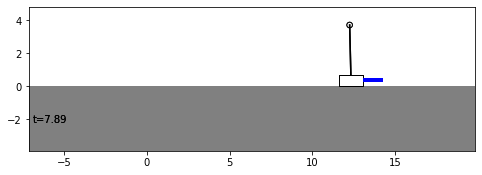

In [13]:
visu2 = viz.Visualizer(res_pid_ukf, pend, dt, speed=1)
anim2 = visu2.animate()
HTML(anim2.to_html5_video())